In [1]:
from scipy import stats
import numpy as np
from pyvbmc import  VBMC
import pickle
from ddm_utils import prob_rt_mu, parse_sim_results, rtd_mu_small_t, prob_rt_generic, prob_rt_mu_posterior
import matplotlib.pyplot as plt


In [2]:
prior_bounds = { 'a_low': 0.1, 'a_high': 3, 'v_low': 0.1, 'v_high': 3 }
with open('prior_bounds.pkl', 'wb') as f:
    pickle.dump(prior_bounds, f)


In [3]:
def log_prior(params):
    v,a = params
    with open('prior_bounds.pkl', 'rb') as f:
        prior_bounds = pickle.load(f)

    v_prior = stats.uniform(prior_bounds['v_low'], prior_bounds['v_high'])
    a_prior = stats.uniform(prior_bounds['a_low'], prior_bounds['a_high'])
    
    log_prior_v = v_prior.logpdf(v)
    log_prior_a = a_prior.logpdf(a)
    return log_prior_v + log_prior_a

def log_like(params):
    v,a = params
    mu = v*(a/2)
    with open('sample_rt.pkl', 'rb') as f:
        t_arr = pickle.load(f)
    
    # t_arr = np.sort(t_arr)
    probs = np.array(prob_rt_mu_posterior(t_arr, mu, 0.25))

    if np.any(probs == 0):
        print('Warning: some probabilities are negative. Setting them to 1e-10')
        print('neg log sum ', np.sum(np.log(probs)))
        probs[probs == 0] = 1e-10
    print('Params = ', params, ' sum log probs = ', np.sum(np.log(probs)))
    
    return np.sum(np.log(probs))

def log_joint(params):
    return log_like(params) + log_prior(params)




# Testing

In [4]:
with open('all_sim_results.pkl', 'rb') as f:
    all_sim_results = pickle.load(f)

a = 2; v = 2;
keyname = f"a={str(a)},v={str(v)}"
choices, RTs = parse_sim_results(all_sim_results[keyname])
with open('sample_rt.pkl', 'wb') as f:
        pickle.dump(RTs, f)


In [5]:
# testing for sum log prob for diff a,v pairs
a = 1; v = 1; print(log_like([a,v]))
a = 2; v = 2; print(log_like([a,v]))
a = 3; v = 3; print(log_like([a,v]))


Params =  [1, 1]  sum log probs =  -441965.6692033715
-441965.6692033715
Params =  [2, 2]  sum log probs =  -427183.2591545308
-427183.2591545308
Params =  [3, 3]  sum log probs =  -500083.84800293855
-500083.84800293855


In [6]:
# read from all_sim_pkl 
with open('all_sim_results.pkl', 'rb') as f:
    all_sim_results = pickle.load(f)

a = 2; v = 2;
keyname = f"a={str(a)},v={str(v)}"
choices, RTs = parse_sim_results(all_sim_results[keyname])
with open('sample_rt.pkl', 'wb') as f:
        pickle.dump(RTs, f)


In [7]:


# v = 2; a = 2; 
lower_bounds = np.array([0.1, 0.1]) 
upper_bounds = np.array([3, 3])
plausible_lower_bounds = np.array([0.5, 0.5])
plausible_upper_bounds = np.array([2.7,2.7])


x0 = np.array([1.8, 1.8])

In [8]:
options = {'display': 'off'}
vbmc = VBMC(log_joint, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, options=options)
vp, results = vbmc.optimize()


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 2).
Reshaping upper bounds to (1, 2).
Reshaping plausible lower bounds to (1, 2).
Reshaping plausible upper bounds to (1, 2).
Casting upper bounds to floating point.
Params =  [1.8 1.8]  sum log probs =  -428493.34108733386
Params =  [2.2529575 2.3936184]  sum log probs =  -432692.6248960419
Params =  [2.40976906 0.63653566]  sum log probs =  -438615.7756462473
Params =  [0.8434085  0.91441387]  sum log probs =  -443114.47308063763
Params =  [2.30105897 2.06872085]  sum log probs =  -428843.0531475666
Params =  [2.64080916 0.58806651]  sum log probs =  -438485.3093080647
Params =  [1.25400339 0.87634806]  sum log probs =  -441404.6364941343
Params =  [2.15871523 2.35217626]  sum log probs =  -430487.5534594949
Params =  [1.61893385 0.61299622]  sum log probs =  -442007.29175681365
Params =  [1.43756957 0.69725356]  sum log probs =  -441952.75155226234
Params =  [1.86471198 2.15547638]  sum log probs =  -427187.0442123424
Params 

# Ground Truth a = 2, v = 2

Text(0, 0.5, 'Frequency')

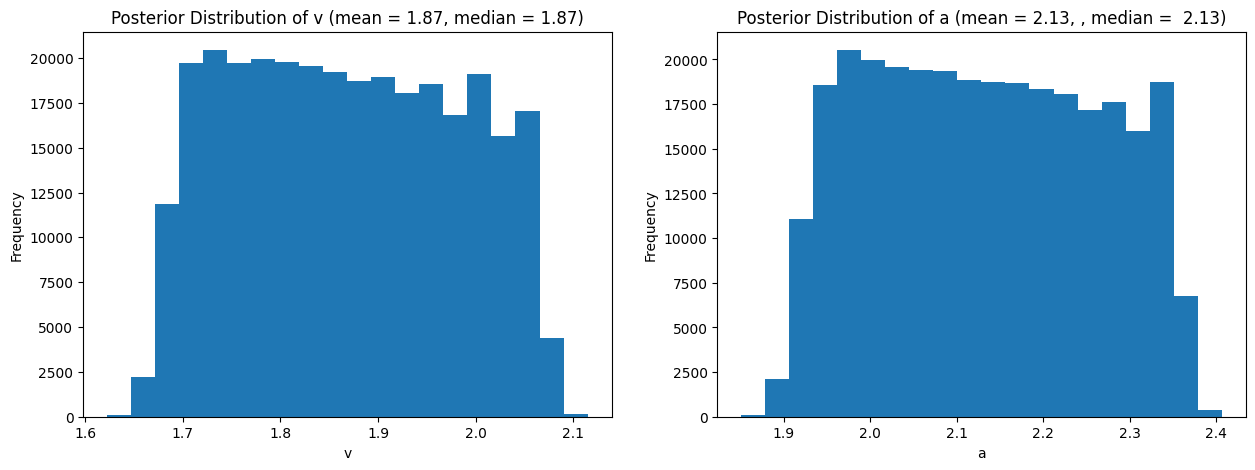

In [11]:
v_a, _ = vp.sample(int(3e5))
v_post = v_a[:,0]
a_post = v_a[:,1]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(v_post, bins=20)
plt.title(f'Posterior Distribution of v (mean = {np.mean(v_post):.2f}, median = {np.median(v_post) :.2f})')
plt.xlabel('v')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(a_post, bins=20)
plt.title(f'Posterior Distribution of a (mean = {np.mean(a_post):.2f}, , median = {np.median(a_post): .2f})')
plt.xlabel('a')
plt.ylabel('Frequency')


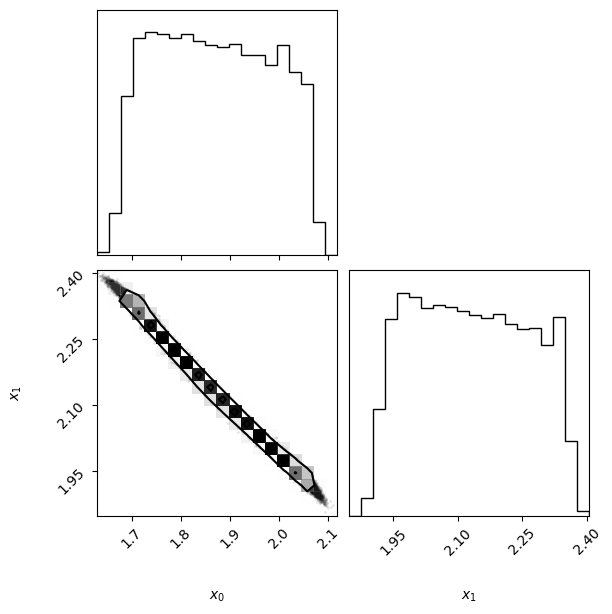

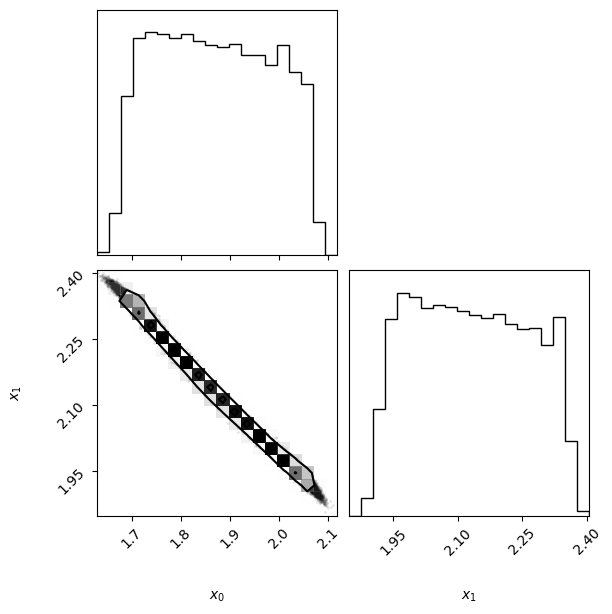

In [12]:
vp.plot()